#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Hurst and RSI Strategy:

This strategy uses a combination of RSI and Hurst coefficient to make trading decisions. 

The rolling Hurst coefficients are calculated using the last 180 bars, the RSI the last 14. 

The Hurst coefficients serve as persistence signal. 
- If RSI > 80 (overbought) and Hurst > .7 (trend will continue), we go with the flow and buy
- If RSI > 80 (overbought) and Hurst < .35 (trend will stop), we go short
- If RSI < 20 (oversold) and Hurst > .7 (trend will continue), we go with the flow and sell
- If RSI < 20 (oversold) and Hurst < .35 (trend will stop), we go long

These thresholds for RSI and Hurst can be easily optimized. But the Hurst exponents take too long to calculate to be optimized. The solution to this issue is presented in the *Hurst and RSI Strategy Optimize* notebook.

We take profits or stop out before putting on a new position. These two parameters can also be optimized.

In [1]:
%load_ext zipline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

import pyfolio as pf
import empyrical
import talib as ta
from hurst import compute_Hc

In [3]:
data = OrderedDict()
data['BTC'] = pd.read_csv("data/btc_2019_aug6_2020.csv",index_col=0,parse_dates=True)

# Zipline only allows trading of whole number of any particular security.
# However, BTC is traded on exchanges in tiny fractions of a single Bitcoin. 
# To allow for realistic backtesting with Zipline, we rescaled the price and volume of BTC
muliplier = 100
data['BTC'].loc[:,'open':'close'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [52]:
from scipy.stats import norm

In [81]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.take_profit = 0
    context.stopped_out = 0
    context.orders_cancelled = 0
    
    context.hh = .73
    context.hl = .2
    context.rh = 86
    context.rl = 32
    
    context.pt = .045
    context.sl = -.015

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='open',
        bar_count=180,
        frequency='1m'
    )
    current_price = price_history[-1]
    rsi = ta.RSI(price_history[-16:],14)[-1]
    hurst = compute_Hc(price_history, kind='price')[0]
        
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on trades
    if not open_orders and not pos_amount:
        if rsi > context.rh and hurst < context.hl or rsi < context.rl and hurst > context.hh:
            order_target_percent(context.security, -0.5, limit_price=current_price * .995)
        elif rsi > context.rh and hurst > context.hh or rsi < context.rl and hurst < context.hl:
            order_target_percent(context.security, 0.5, limit_price=current_price * 1.005)
    
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=30):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1

    # take profits or stop losses
    elif not open_orders and pos_amount:
        if pos_amount<0:
            prct_changed = (filled_price-current_price)/filled_price
        else:
            prct_changed = (current_price-filled_price)/filled_price
        if prct_changed >= context.pt:
            order_target_percent(context.security, 0)
            context.take_profit += 1
        elif prct_changed <= context.sl:
            order_target_percent(context.security, 0)
            context.stopped_out += 1
        
    record(stopped_out = context.stopped_out, take_profits = context.take_profit, cancelled = context.orders_cancelled)


In [ ]:
# Added t-stat signal but didn't really help here

'''
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.take_profit = 0
    context.stopped_out = 0
    context.orders_cancelled = 0
    
    context.hh = .7
    context.hl = .35
    context.rh = 80
    context.rl = 20
    
    context.pt = .045
    context.sl = -.015

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='open',
        bar_count=180,
        frequency='1m'
    )
    current_price = price_history[-1]
    rsi = ta.RSI(price_history[-16:],14)[-1]
    hurst = compute_Hc(price_history, kind='price')[0]
    rets = price_history.pct_change().dropna()
    proportion = norm.cdf(rets.mean()/(rets.std()/np.sqrt(180)))
        
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on trades
    if not open_orders and not pos_amount:
        if rsi > context.rh and hurst < context.hl or rsi < context.rl and hurst > context.hh:
            order_target_percent(context.security, -0.5*proportion, limit_price=current_price * .995)
        elif rsi > context.rh and hurst > context.hh or rsi < context.rl and hurst < context.hl:
            order_target_percent(context.security, 0.5*proportion, limit_price=current_price * 1.005)
    
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=30):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1

    # take profits or stop losses
    elif not open_orders and pos_amount:
        if pos_amount<0:
            prct_changed = (filled_price-current_price)/filled_price
        else:
            prct_changed = (current_price-filled_price)/filled_price
        if prct_changed >= context.pt:
            order_target_percent(context.security, 0)
            context.take_profit += 1
        elif prct_changed <= context.sl:
            order_target_percent(context.security, 0)
            context.stopped_out += 1
        
    record(stopped_out = context.stopped_out, take_profits = context.take_profit, cancelled = context.orders_cancelled)
    
'''

In [73]:
perf = zipline.run_algorithm(start=datetime(2020, 5, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 7, 10, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=10000,
                      data_frequency ='minute',
                      data=panel)

/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [18]:
orders = perf.orders.apply(lambda x: x if len(x)!= 0 else 0)
orders = orders[orders!=0]

#### Performance plots for the case with t-stat proportion for position sizing and the case without

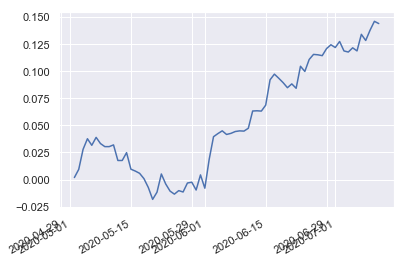

In [74]:
# {'hh': 0.7, 'hl': 0.35, 'rh': 80, 'rl': 20}
# proportion added
perf.algorithm_period_return.plot()

In [79]:
perf.short_exposure[perf.short_exposure!=0]

2020-05-03 23:59:00+00:00   -4097.450
2020-05-10 23:59:00+00:00   -3411.720
2020-05-13 23:59:00+00:00   -4556.755
2020-05-15 23:59:00+00:00   -2606.660
2020-05-16 23:59:00+00:00   -2627.660
2020-05-17 23:59:00+00:00   -2805.170
2020-05-19 23:59:00+00:00   -2348.760
2020-05-20 23:59:00+00:00   -2282.640
2020-06-12 23:59:00+00:00   -3783.800
2020-06-13 23:59:00+00:00   -3786.600
2020-06-14 23:59:00+00:00   -3731.800
2020-06-23 23:59:00+00:00   -3175.590
2020-06-24 23:59:00+00:00   -3065.205
2020-07-08 23:59:00+00:00   -3776.000
2020-07-09 23:59:00+00:00   -3694.200
2020-07-10 23:59:00+00:00   -3714.800
Name: short_exposure, dtype: float64

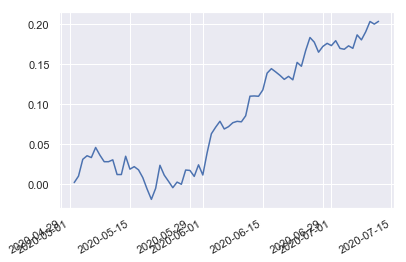

In [39]:
# {'hh': 0.7, 'hl': 0.35, 'rh': 80, 'rl': 20}
# no proportion
perf.algorithm_period_return.plot()

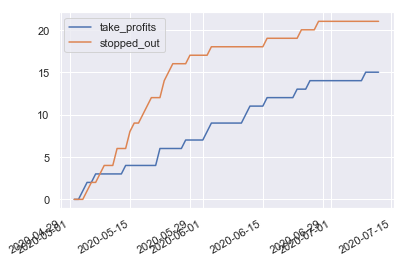

In [40]:
# {'hh': 0.7, 'hl': 0.35, 'rh': 80, 'rl': 20}
# no proportion
perf.take_profits.plot()
perf.stopped_out.plot()
plt.legend()

#### Try again with a different set of parameters

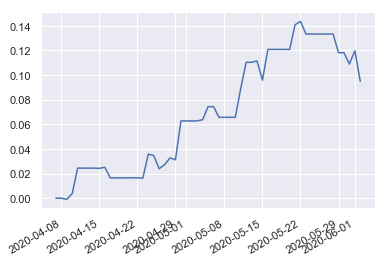

In [57]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
# with proportion added
perf.algorithm_period_return.plot()

In [66]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
# with proportion added
perf.short_exposure[perf.short_exposure!=0]

2020-04-08 23:59:00+00:00   -4784.975
2020-04-09 23:59:00+00:00   -4738.175
2020-04-13 23:59:00+00:00    -137.060
2020-04-15 23:59:00+00:00    -264.640
2020-04-20 23:59:00+00:00    -136.710
2020-04-21 23:59:00+00:00    -137.000
2020-04-23 23:59:00+00:00   -4712.400
2020-04-24 23:59:00+00:00   -4724.685
2020-05-03 23:59:00+00:00   -4275.600
2020-05-05 23:59:00+00:00   -4971.450
2020-05-13 23:59:00+00:00   -5021.730
2020-05-19 23:59:00+00:00   -5186.845
2020-05-21 23:59:00+00:00   -5509.520
2020-05-31 23:59:00+00:00   -5013.800
Name: short_exposure, dtype: float64

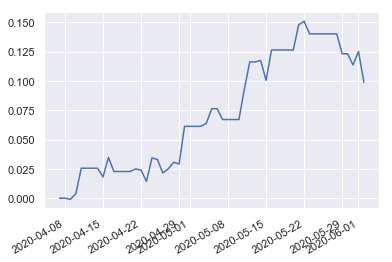

In [61]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
# no proportion
perf.algorithm_period_return.loc[:'2020-06-01'].plot()

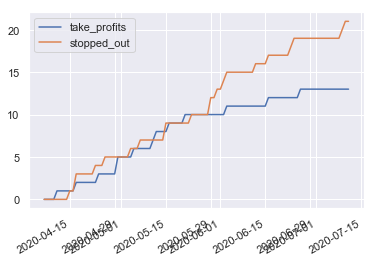

In [47]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
# no proportion
perf.take_profits.plot()
perf.stopped_out.plot()
plt.legend()

#### Returns plot did not print out properly in the tear sheet below

In [41]:
# {'hh': 0.7, 'hl': 0.35, 'rh': 80, 'rl': 20}
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(perf)

Start date,2020-05-01
End date,2020-07-11
Total months,3
,Backtest
Annual return,91.3%
Cumulative returns,20.4%
Annual volatility,17.0%
Sharpe ratio,3.90
Calmar ratio,14.72
Stability,0.85
Max drawdown,-6.2%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.20,2020-05-06,2020-05-19,2020-06-02,20
1,1.56,2020-06-25,2020-06-27,2020-07-06,8
2,1.22,2020-06-16,2020-06-21,2020-06-22,5
3,0.89,2020-06-04,2020-06-05,2020-06-10,5
4,0.53,2020-07-06,2020-07-07,2020-07-08,3


Stress Events,mean,min,max
New Normal,0.26%,-1.79%,2.90%


Top 10 long positions of all time,max
sid,
BTC,50.41%


Top 10 short positions of all time,max
sid,
BTC,-49.95%


Top 10 positions of all time,max
sid,
BTC,50.41%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


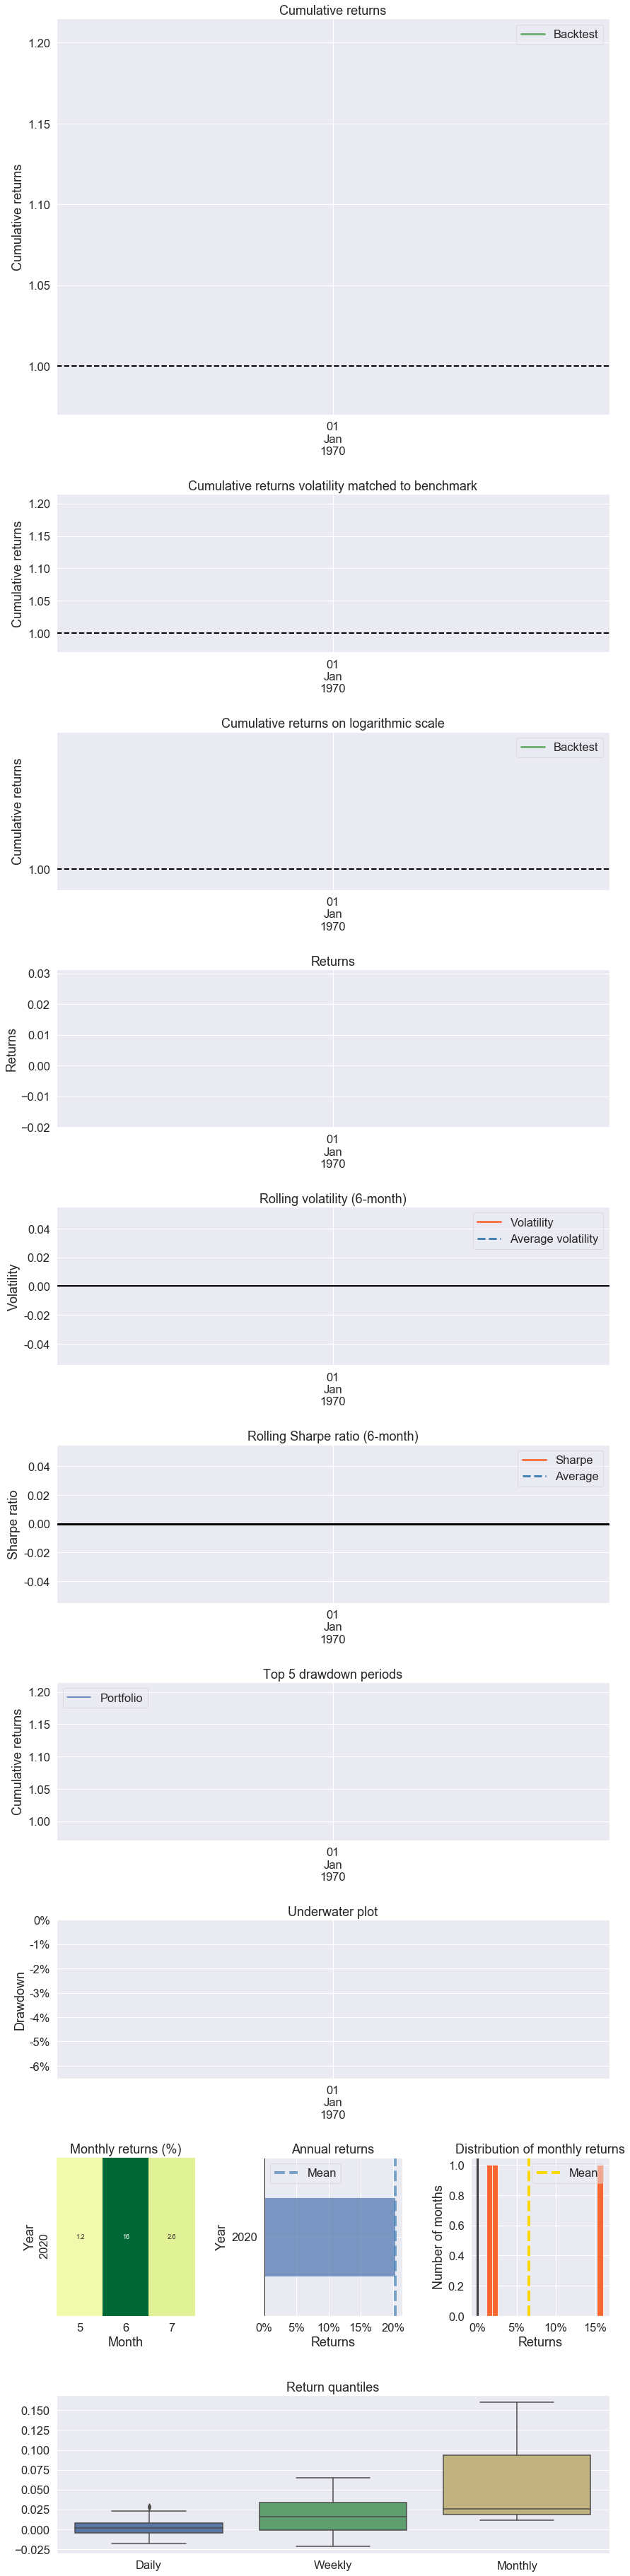

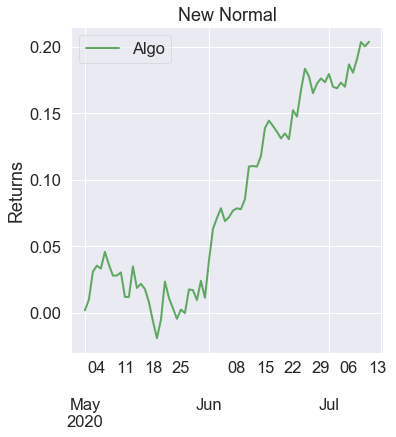

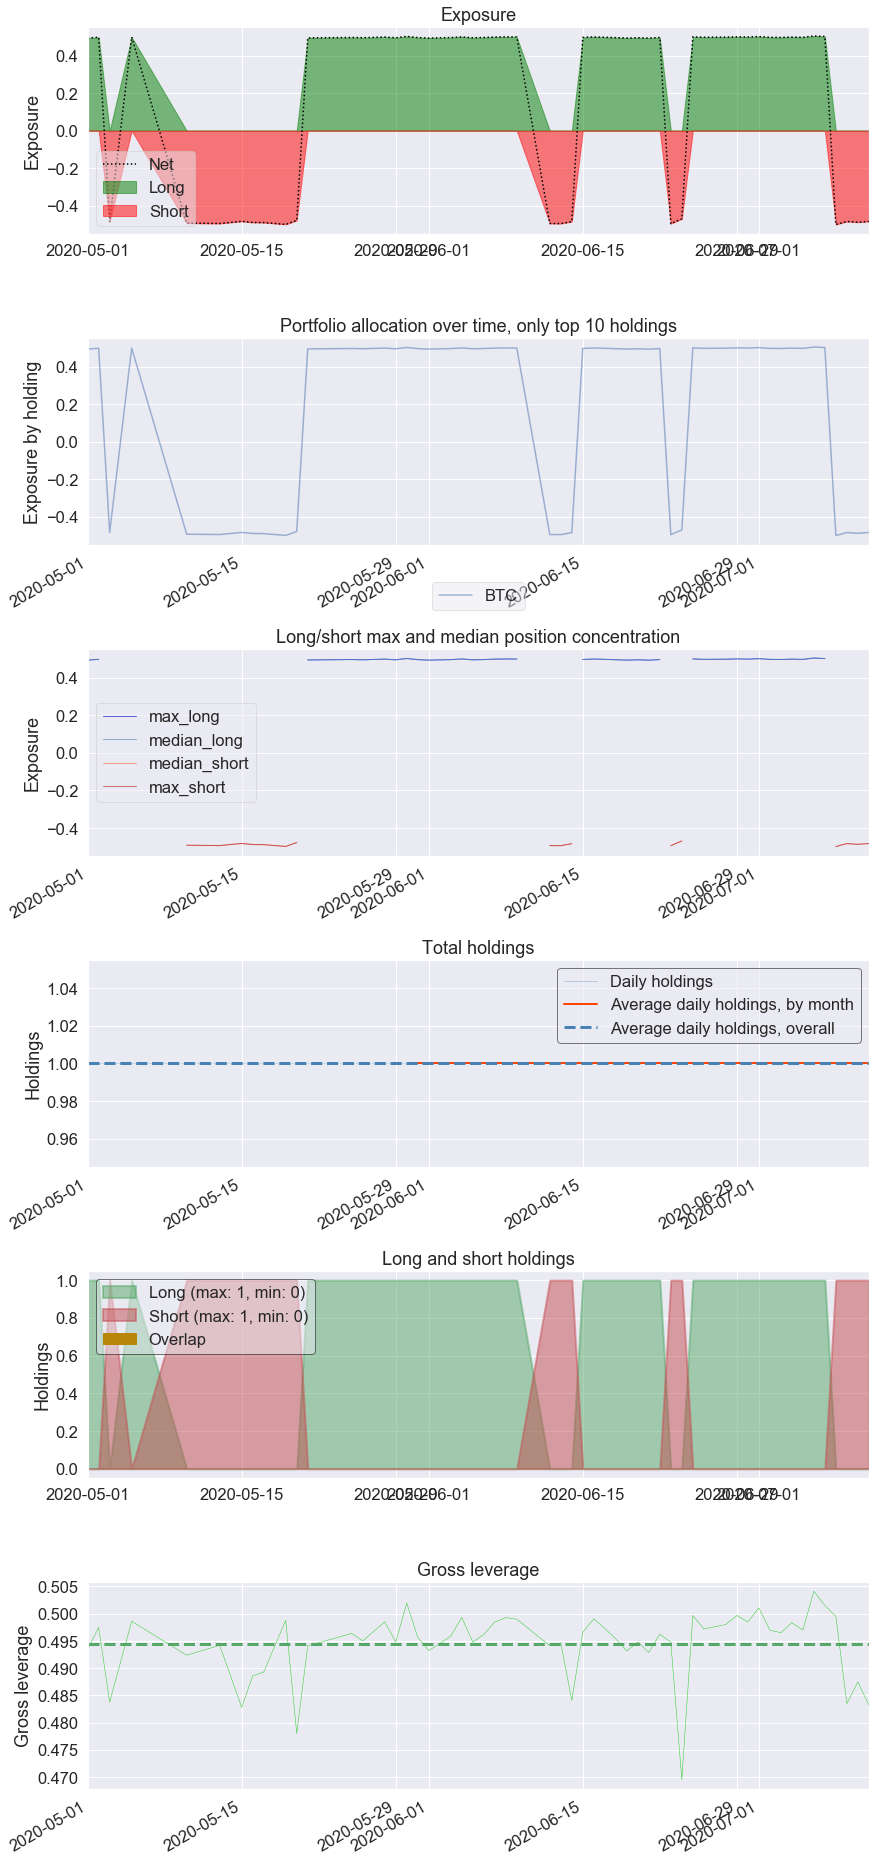

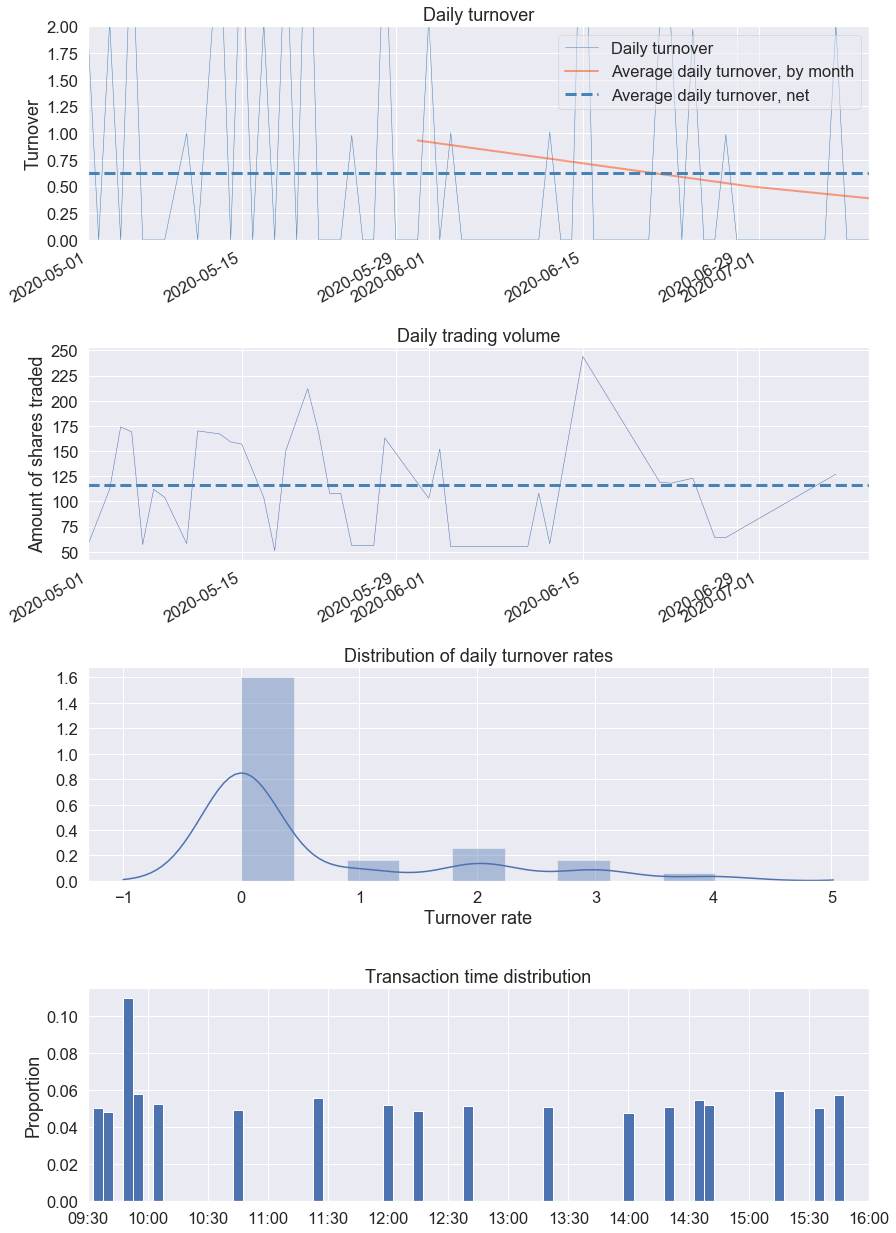

In [42]:
# {'hh': 0.7, 'hl': 0.35, 'rh': 80, 'rl': 20}
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions)

In [50]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(perf)

Start date,2020-04-06
End date,2020-07-10
Total months,4
,Backtest
Annual return,33.4%
Cumulative returns,11.6%
Annual volatility,14.9%
Sharpe ratio,2.00
Calmar ratio,7.38
Stability,0.73
Max drawdown,-4.5%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.52,2020-05-21,2020-06-01,NaT,NaN
1,1.98,2020-04-15,2020-04-22,2020-04-29,11
2,1.51,2020-05-13,2020-05-14,2020-05-15,3
3,0.86,2020-05-05,2020-05-06,2020-05-10,4
4,0.73,2020-04-12,2020-04-14,2020-04-15,3


Stress Events,mean,min,max
New Normal,0.12%,-2.35%,3.13%


Top 10 long positions of all time,max
sid,
BTC,50.51%


Top 10 short positions of all time,max
sid,
BTC,-50.57%


Top 10 positions of all time,max
sid,
BTC,50.57%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


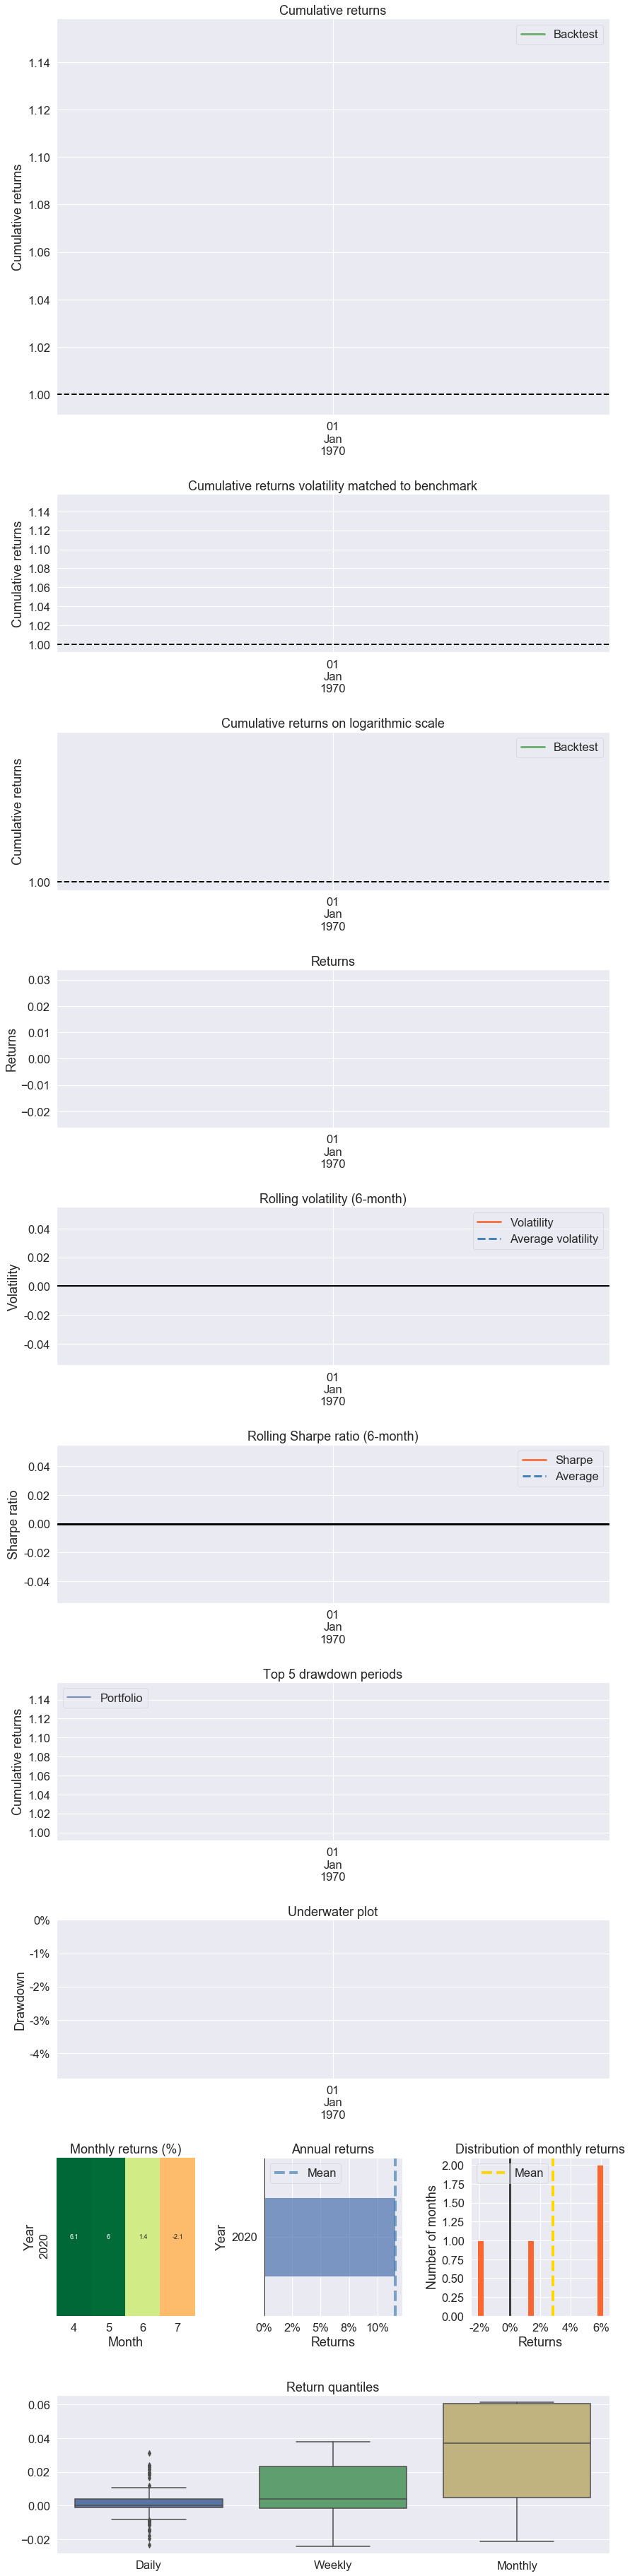

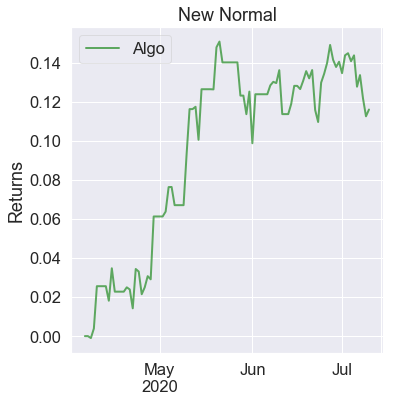

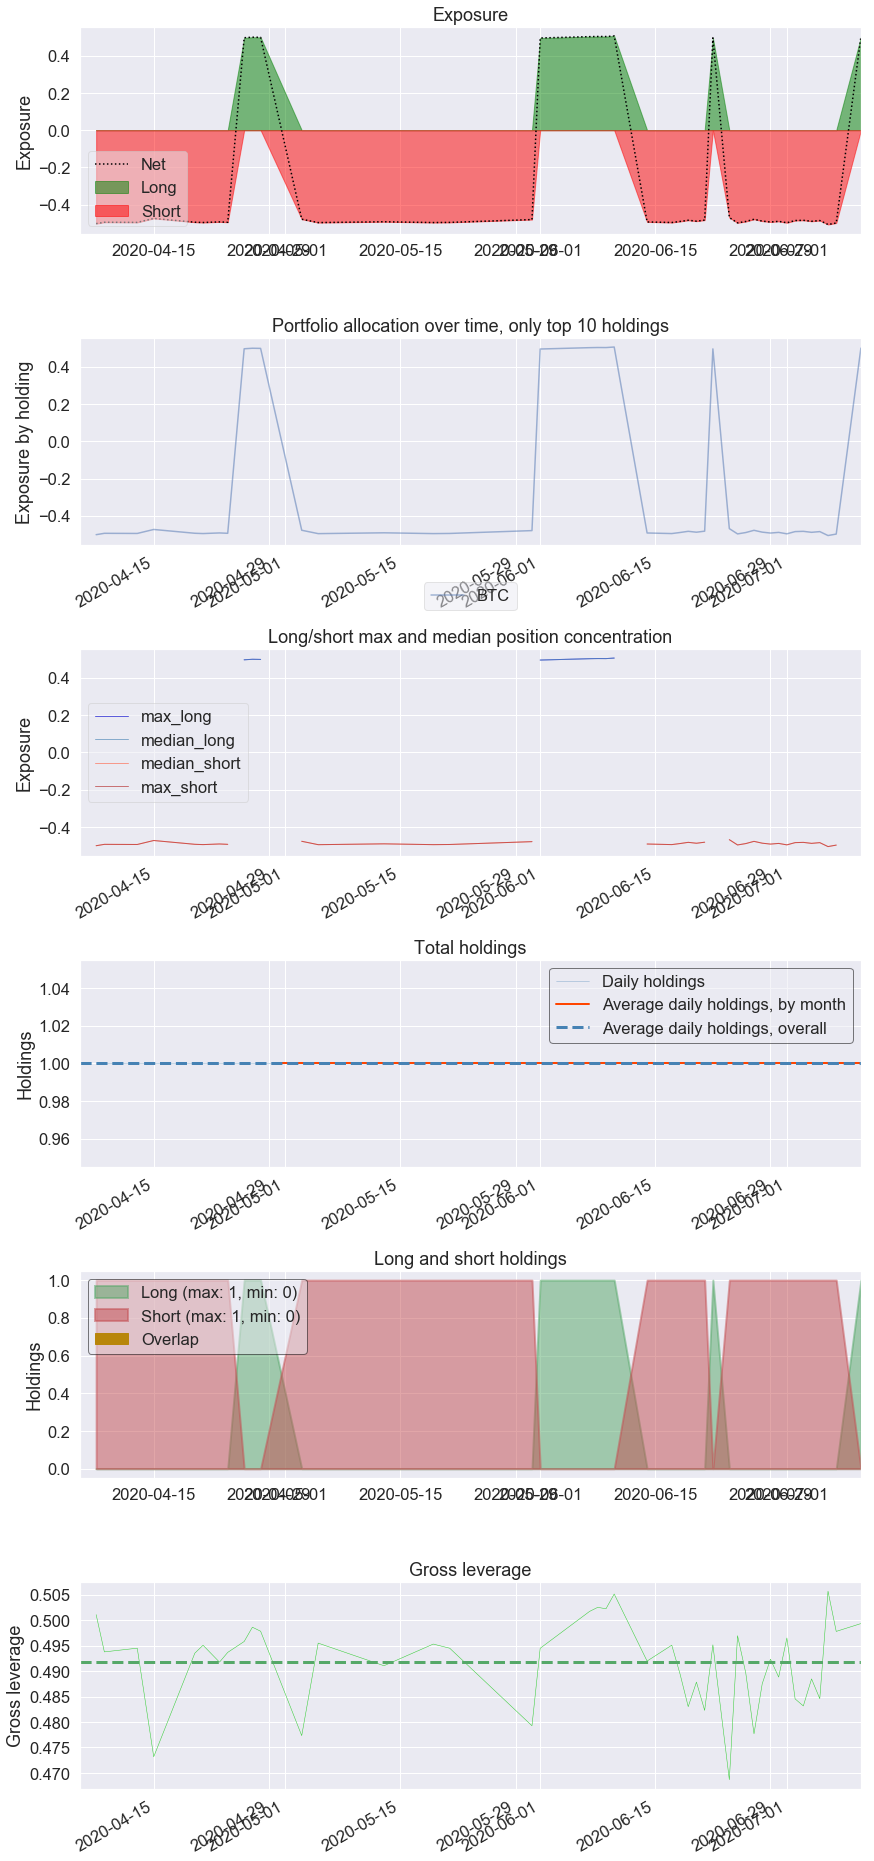

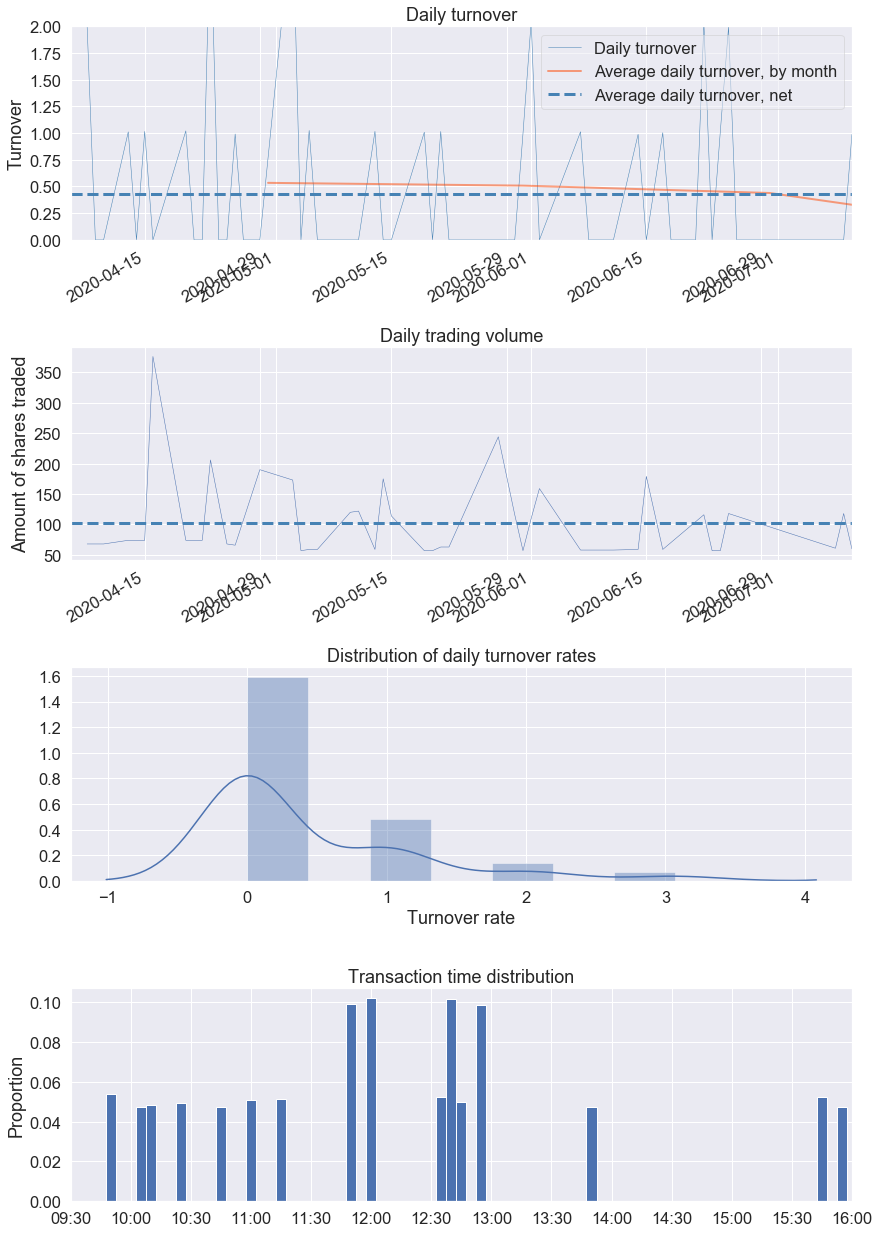

In [51]:
# {'hh': 0.73, 'hl': 0.2, 'rh': 86.0, 'rl': 32.0}
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions)